In [ ]:
import numpy as np

In [18]:
import gsd.hoomd
import numpy as np

def compute_all_flake_coms(flake_positions, box_lengths, beads_per_flake=50):
    Lx, Ly, Lz = box_lengths
    n_flakes = len(flake_positions) // beads_per_flake
    flake_coms = []

    for i in range(n_flakes):
        flake = flake_positions[i * beads_per_flake : (i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        com = np.mean(unwrapped, axis=0)
        flake_coms.append(com)

    return np.array(flake_coms)

def find_flake_neighbors(coms, box_lengths, cutoff=2.5):
    Lx, Ly, Lz = box_lengths
    n = len(coms)
    for i in range(n):
        neighbors = []
        for j in range(n):
            if i == j:
                continue
            # Minimum image convention
            dr = coms[j] - coms[i]
            dr[0] -= Lx * np.round(dr[0] / Lx)
            dr[1] -= Ly * np.round(dr[1] / Ly)
            dr[2] -= Lz * np.round(dr[2] / Lz)
            dist = np.linalg.norm(dr)
            if dist < cutoff:
                neighbors.append((j, dist))
        if neighbors:
            neighbor_str = ", ".join([f"Flake {j} (distance: {d:.2f})" for j, d in neighbors])
            print(f"Flake {i} is neighbors with: {neighbor_str}")
        else:
            print(f"Flake {i} has no neighbors within cutoff.")

traj = gsd.hoomd.open("100_10mer10f_0.0005dt_7kT_large.gsd")
frame = traj[93220]  # frame index

flake_type = "F"
flake_typeid = frame.particles.types.index(flake_type)
positions = frame.particles.position
typeids = frame.particles.typeid
flake_positions = positions[typeids == flake_typeid]

Lx, Ly, Lz = frame.configuration.box[:3]

flake_coms = compute_all_flake_coms(flake_positions, (Lx, Ly, Lz), beads_per_flake=50)
find_flake_neighbors(flake_coms, (Lx, Ly, Lz), cutoff=2.5)

Flake 0 has no neighbors within cutoff.
Flake 1 has no neighbors within cutoff.
Flake 2 is neighbors with: Flake 6 (distance: 1.15), Flake 8 (distance: 2.27)
Flake 3 has no neighbors within cutoff.
Flake 4 has no neighbors within cutoff.
Flake 5 has no neighbors within cutoff.
Flake 6 is neighbors with: Flake 2 (distance: 1.15)
Flake 7 has no neighbors within cutoff.
Flake 8 is neighbors with: Flake 2 (distance: 2.27), Flake 9 (distance: 2.17)
Flake 9 is neighbors with: Flake 8 (distance: 2.17)


In [ ]:
data = np.genfromtxt("500_10mer10f_0.0005dt_7kT_large.txt", names=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(data["flowermdbasesimulationSimulationtimestep"][5001:], np.array(data["mdcomputeThermodynamicQuantitiespotential_energy"][5001:])/1500)
plt.ylabel("PE/N")
plt.xlabel("t")
plt.title("PE/N v t, 100 10mers, 10 flakes, kT = 3")

In [ ]:
len(data["flowermdbasesimulationSimulationtimestep"])

In [ ]:
import numpy as np

pe = data["mdcomputeThermodynamicQuantitiespotential_energy"][5001:]
print("Mean PE:", np.mean(pe))
print("Std PE:", np.std(pe))

In [ ]:
import freud
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt

# === Load trajectory ===
traj = gsd.hoomd.open("100_10mer10f_0.0005dt_7kT_large.gsd")
total_frames = len(traj)
print(len(traj))

# === Parameters ===
flake_type = "F"
flake_typeid = traj[0].particles.types.index(flake_type)
n_flakes = 10
beads_per_flake = 50
bins = 40

# === Custom frame ranges ===
frame_ranges = [
    ("Beginning frames", 5001, 5050),
    ("Middle frames", 93200, 93250),
    ("Final frames", 10450, 10500)
]

# === RDF function ===
def compute_flake_rdf(frame):
    positions = frame.particles.position
    typeids = frame.particles.typeid
    Lx, Ly, Lz = frame.configuration.box[:3]

    flake_beads = positions[typeids == flake_typeid]

    # === Manual wrapping of bead positions into the box ===
    wrapped_positions = np.empty_like(flake_beads)
    wrapped_positions[:, 0] = flake_beads[:, 0] % Lx
    wrapped_positions[:, 1] = flake_beads[:, 1] % Ly
    wrapped_positions[:, 2] = flake_beads[:, 2] % Lz

    # === Unwrapping within each flake before computing CoM ===
    flake_CoMs = []
    for i in range(n_flakes):
        flake = wrapped_positions[i * beads_per_flake:(i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Apply minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        flake_CoMs.append(np.mean(unwrapped, axis=0))

    flake_CoMs = np.array(flake_CoMs)

    # Compute RDF
    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    rdf = freud.density.RDF(bins=bins, r_max=Lx/4, r_min = 0)
    rdf.compute(system=(box, flake_CoMs), reset=True)

    return rdf.bin_centers, rdf.rdf


# === Averaging wrapper ===
def average_rdf(start, end):
    rdf_accum = None
    for i in range(start, end):
        r, g_r = compute_flake_rdf(traj[i])
        if rdf_accum is None:
            rdf_accum = np.zeros_like(g_r)
        rdf_accum += g_r
    return r, rdf_accum / (end - start)

# === Plot RDFs ===
plt.figure(figsize=(8, 5))

for label, start, end in frame_ranges:
    r_vals, g_r_avg = average_rdf(start, end)
    plt.plot(r_vals, g_r_avg, label=label)
    print(np.max(g_r_avg))

plt.xlabel("r (distance between flake CoMs)")
plt.ylabel("g(r)")
plt.title("10 flakes, 100 10mers, kT = 7, 100e6 steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

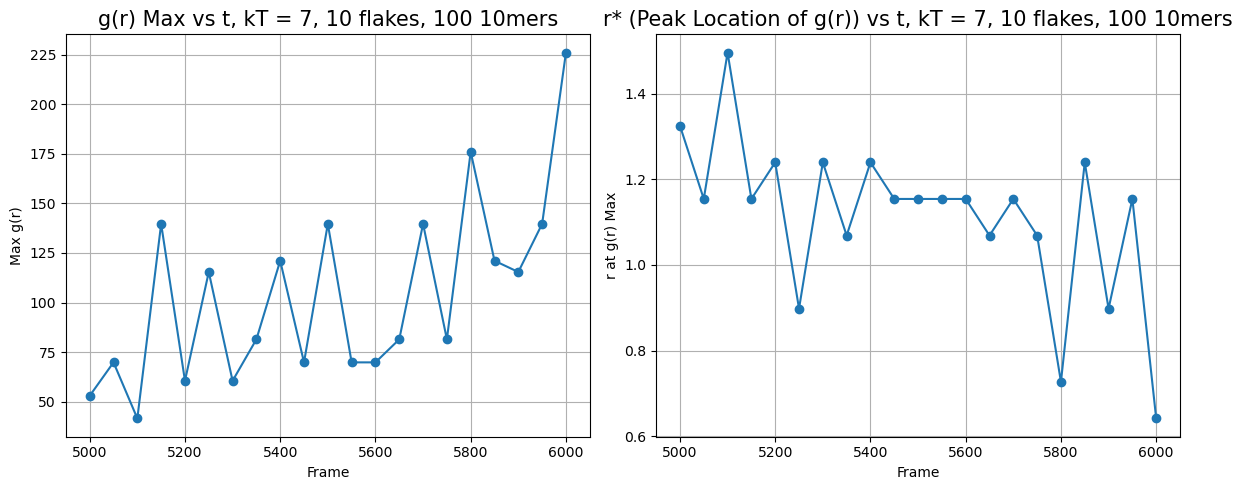

In [2]:
import gsd.hoomd
import freud
import numpy as np
import matplotlib.pyplot as plt

# === Load trajectory ===
traj = gsd.hoomd.open("100_10mer10f_0.0005dt_energy_driven.gsd")
total_frames = len(traj)

# === Parameters ===
flake_type = "F"
flake_typeid = traj[0].particles.types.index(flake_type)
n_flakes = 10
beads_per_flake = 50
bins = 50
sample_interval = 50  # <== adjust this as needed

g_r_max_values = []
r_at_max_values = []
frame_indices = []

# === RDF with unwrapped CoM calculation ===
def compute_max_rdf_info(frame):
    positions = frame.particles.position
    typeids = frame.particles.typeid
    Lx, Ly, Lz = frame.configuration.box[:3]

    flake_beads = positions[typeids == flake_typeid]
    flake_CoMs = []

    for i in range(n_flakes):
        flake = flake_beads[i * beads_per_flake:(i + 1) * beads_per_flake]
        ref = flake[0].copy()
        unwrapped = np.zeros_like(flake)

        for j, bead in enumerate(flake):
            delta = bead - ref
            delta -= np.round(delta / np.array([Lx, Ly, Lz])) * np.array([Lx, Ly, Lz])
            unwrapped[j] = ref + delta

        com = np.mean(unwrapped, axis=0) % np.array([Lx, Ly, Lz])
        flake_CoMs.append(com)

    flake_CoMs = np.array(flake_CoMs)

    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    rdf = freud.density.RDF(bins=bins, r_max=Lx / 4)
    rdf.compute(system=(box, flake_CoMs), reset=True)

    g_r = rdf.rdf
    r_vals = rdf.bin_centers
    idx_max = np.argmax(g_r)
    return g_r[idx_max], r_vals[idx_max]

# === Loop over trajectory with sampling ===
for i in range(5000, total_frames, sample_interval):
    g_max, r_at_max = compute_max_rdf_info(traj[i])
    g_r_max_values.append(g_max)
    r_at_max_values.append(r_at_max)
    frame_indices.append(i)

# === Plot results ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(frame_indices, g_r_max_values, marker='o')
plt.xlabel("Frame")
plt.ylabel("Max g(r)")
plt.title("g(r) Max vs t, kT = 7, 10 flakes, 100 10mers",fontsize = 15)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(frame_indices, r_at_max_values, marker='o')
plt.xlabel("Frame")
plt.ylabel("r at g(r) Max")
plt.title("r* (Peak Location of g(r)) vs t, kT = 7, 10 flakes, 100 10mers", fontsize = 15)
plt.grid(True)

plt.tight_layout()
plt.show()

Decor. time of g(r): 250.00 steps
Decor. time of r*: 50.00 steps


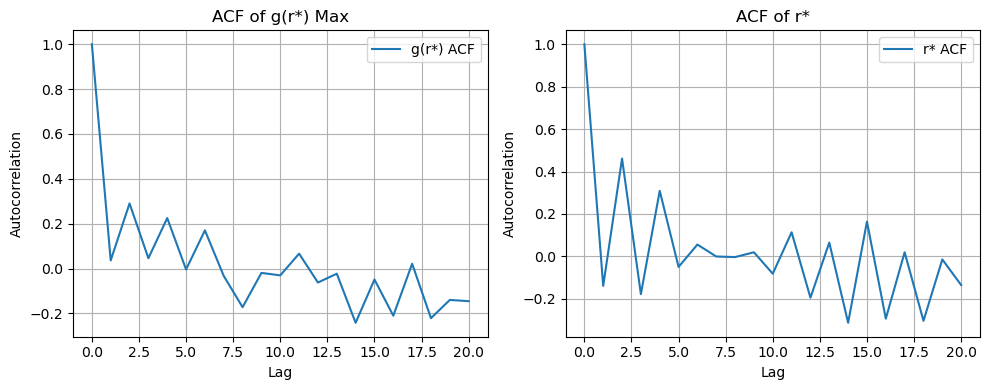

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

def compute_acf(signal):
    """Returns normalized autocorrelation of a 1D signal."""
    signal = signal - np.mean(signal)
    corr = correlate(signal, signal, mode='full')
    mid = len(corr) // 2
    acf = corr[mid:] / corr[mid]  # Normalize to 1 at lag 0
    return acf

def estimate_decorrelation_time(acf, dt=1):
    """Estimate decorrelation time as the first lag where ACF < 1/e."""
    threshold = 0
    for lag, value in enumerate(acf):
        if value < threshold:
            return lag * dt
    return len(acf) * dt  # fallback if threshold not crossed

# === Run on your g(r) max and r* arrays ===
g_r_max_acf = compute_acf(g_r_max_values)
r_star_acf = compute_acf(r_at_max_values)

g_r_decorrelation_time = estimate_decorrelation_time(g_r_max_acf, dt=sample_interval)
r_star_decorrelation_time = estimate_decorrelation_time(r_star_acf, dt=sample_interval)

print(f"Decor. time of g(r): {g_r_decorrelation_time:.2f} steps")
print(f"Decor. time of r*: {r_star_decorrelation_time:.2f} steps")

# === Plot ACFs with 1/e threshold ===
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(g_r_max_acf, label="g(r*) ACF")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("ACF of g(r*) Max")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(r_star_acf, label="r* ACF")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("ACF of r*")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


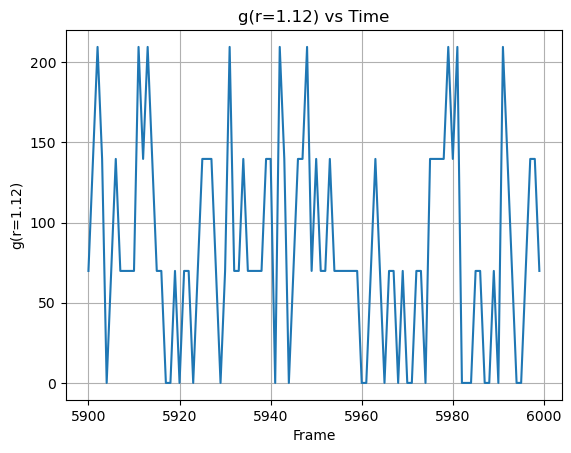

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def compute_flake_rdf(frame):
    positions = frame.particles.position
    typeids = frame.particles.typeid
    Lx, Ly, Lz = frame.configuration.box[:3]

    # === Extract only flake beads ===
    flake_beads = positions[typeids == flake_typeid]

    # === Wrap beads into the box manually ===
    wrapped_positions = np.empty_like(flake_beads)
    wrapped_positions[:, 0] = flake_beads[:, 0] % Lx
    wrapped_positions[:, 1] = flake_beads[:, 1] % Ly
    wrapped_positions[:, 2] = flake_beads[:, 2] % Lz

    # === Unwrap each flake's beads around a reference ===
    flake_CoMs = []
    for i in range(n_flakes):
        flake = wrapped_positions[i * beads_per_flake:(i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        flake_CoMs.append(np.mean(unwrapped, axis=0))

    flake_CoMs = np.array(flake_CoMs)

    # === Compute RDF between flake CoMs ===
    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    rdf = freud.density.RDF(bins=bins, r_max=Lx / 4, r_min=0)
    rdf.compute(system=(box, flake_CoMs), reset=True)

    return rdf.bin_centers, rdf.rdf

# === Parameters ===
target_r = 1.12  # the distance you want to monitor
tolerance = 0.05  # how close to r=2.45 you allow
g_r_at_r_values = []
frame_indices = []

# === Loop through trajectory and extract g(r=2.45) ===
for i in range(5000, len(traj)):
    r_vals, g_r_vals = compute_flake_rdf(traj[i])
    
    # Find index of r closest to target_r within tolerance
    idx = np.argmin(np.abs(r_vals - target_r))
    
    if np.abs(r_vals[idx] - target_r) <= tolerance:
        g_r_at_r_values.append(g_r_vals[idx])
        frame_indices.append(i)
    else:
        # skip this frame if no close enough bin found
        continue

# === Plot g(r=2.45) vs time ===
plt.figure()
plt.plot(frame_indices[900:1000], g_r_at_r_values[900:1000])
plt.xlabel("Frame")
plt.ylabel(f"g(r={target_r})")
plt.title(f"g(r={target_r}) vs Time")
plt.grid(True)
plt.show()


In [ ]:
import freud
import gsd.hoomd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# === Load trajectory ===
traj = gsd.hoomd.open("100_10mer10f_0.0005dt_7kT_large.gsd")
total_frames = len(traj)

# === Parameters ===
flake_type = "F"
flake_typeid = traj[0].particles.types.index(flake_type)
n_flakes = 10
beads_per_flake = 50
bins = 25

# === RDF computation ===
def compute_flake_rdf(frame):
    positions = frame.particles.position
    typeids = frame.particles.typeid
    Lx, Ly, Lz = frame.configuration.box[:3]

    flake_beads = positions[typeids == flake_typeid]

    # === Manual wrapping of bead positions into the box ===
    wrapped_positions = np.empty_like(flake_beads)
    wrapped_positions[:, 0] = flake_beads[:, 0] % Lx
    wrapped_positions[:, 1] = flake_beads[:, 1] % Ly
    wrapped_positions[:, 2] = flake_beads[:, 2] % Lz

    # === Unwrapping within each flake before computing CoM ===
    flake_CoMs = []
    for i in range(n_flakes):
        flake = wrapped_positions[i * beads_per_flake:(i + 1) * beads_per_flake]
        ref = flake[0]
        delta = flake - ref

        # Apply minimum image convention
        delta[:, 0] -= Lx * np.round(delta[:, 0] / Lx)
        delta[:, 1] -= Ly * np.round(delta[:, 1] / Ly)
        delta[:, 2] -= Lz * np.round(delta[:, 2] / Lz)

        unwrapped = ref + delta
        flake_CoMs.append(np.mean(unwrapped, axis=0))

    flake_CoMs = np.array(flake_CoMs)

    # Compute RDF
    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    rdf = freud.density.RDF(bins=bins, r_max=Lx / 4)
    rdf.compute(system=(box, flake_CoMs), reset=True)

    return rdf.bin_centers, rdf.rdf

# === Sample and plot RDFs at 100k frame intervals ===
interval = 1000000
sampled_indices = list(range(91143, total_frames, interval))
colors = cm.cividis(np.linspace(0, 1, len(sampled_indices)))  # color map without yellow
fig, ax = plt.subplots(figsize=(10, 6))

for i, color in zip(sampled_indices, colors):
    r_vals, g_r = compute_flake_rdf(traj[i])
    ax.plot(r_vals, g_r, color=color)

ax.set_xlabel("r (distance between flake CoMs)")
ax.set_ylabel("g(r)")
ax.set_title("Flake–Flake RDFs at 100k Frame Intervals")
#plt.ylim(0, 5)
plt.xlim(0, 6)

ax.grid(True)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cm.cividis, norm=plt.Normalize(vmin=sampled_indices[0], vmax=sampled_indices[-1]))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="Frame Index")

plt.tight_layout()
plt.show()


In [ ]:
import gsd.hoomd

# Load your trajectory
traj = gsd.hoomd.open("100_10mer10f_0.0005dt_3kT_large.gsd")

# Access a frame (e.g., frame 0)
frame = traj[5001]

# Print box lengths (Lx, Ly, Lz)
Lx, Ly, Lz = frame.configuration.box[:3]
print(f"Lx = {Lx}, Ly = {Ly}, Lz = {Lz}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def autocorrelation(x):
    """
    Compute the normalized autocorrelation function of a 1D signal x.
    """
    x = np.array(x)
    x -= np.mean(x)  # subtract mean
    result = np.correlate(x, x, mode='full')  # full autocorrelation
    result = result[result.size // 2:]  # take second half
    result /= result[0]  # normalize
    return result

# Example usage:
# Assume `PE` is your potential energy array
acf = autocorrelation(pe)

# Plotting the autocorrelation function
plt.plot(acf[0:])
plt.xlabel('Lag')
plt.ylabel('Normalized Autocorrelation')
plt.title('Autocorrelation of Potential Energy vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def decorrelation_time(acf, max_lag=None):
    """
    Estimate the decorrelation time τ_int from an autocorrelation function.

    Parameters:
        acf (array): Normalized autocorrelation function.
        max_lag (int, optional): Maximum lag to sum over (default: until acf < 0).

    Returns:
        tau_int (float): Estimated decorrelation time.
    """
    if max_lag is None:
        # Find where ACF drops below zero for the first time
        zero_crossings = np.where(acf < 0)[0]
        if len(zero_crossings) == 0:
            max_lag = len(acf)
        else:
            max_lag = zero_crossings[0]

    tau_int = 1 + 2 * np.sum(acf[1:max_lag])
    return tau_int


In [ ]:
decorrelation_time(acf)